# Model Explainability with SHAP: A Guide to Those Who Are Serious About Machine Learning
## SUBTITLE TODO
![](images/pexels.jpg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@iriser?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Irina Iriser</a>
        on 
        <a href=https://www.pexels.com/photo/blue-and-red-jellyfish-artwork-1086583/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels''></a>
    </strong>
</figcaption>

# Setup

In [1]:
import logging
import time
import warnings

import catboost as cb
import datatable as dt
import joblib
import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import shap
import xgboost as xgb
from optuna.samplers import TPESampler
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.impute import SimpleImputer
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

logging.basicConfig(
    format="%(asctime)s - %(message)s", datefmt="%d-%b-%y %H:%M:%S", level=logging.INFO
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")
pd.set_option("float_format", "{:.5f}".format)

In [4]:
# For regression
diamonds = sns.load_dataset("diamonds")

X, y = diamonds.drop("price", axis=1), diamonds[["price"]].values.flatten()

# Encode cats
oe = OrdinalEncoder()
cats = X.select_dtypes(exclude=np.number).columns.tolist()
X.loc[:, cats] = oe.fit_transform(X[cats])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=1121218
)

In [3]:
# For classification - HIDE
diamonds = sns.load_dataset("diamonds")

X, y = diamonds.drop("cut", axis=1), diamonds[["cut"]].values.flatten()

# Encode cats
oe = OrdinalEncoder()
cats = X.select_dtypes(exclude=np.number).columns.tolist()
X.loc[:, cats] = oe.fit_transform(X[cats])

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.15, random_state=1121218
)

# Motivation

Today, you can't just come up to your boss and say, "Here is my best model. Let's put it into production and be happy!". No, it doesn't work that way now. Companies and businesses are being picky over the adoption of AI solutions because of their "black box" nature. They **demand** explainability. 

If ML specialists are coming up with tools to understand and explain the tools *they* created, the concerns and suspicions of non-technical folks is entirely justified. One of those tools introduced a few years ago is SHAP. It has the ability to break down mechanics of any machine learning model and deep neural net to make them understandable to anyone. TODO 

Today, we will learn how exactly SHAP works and how you can use it for classical ML tasks in your own practice. 

# What is SHAP and Shapley values?

SHAP (SHapley Additive exPlanations) is a Python package based on the 2016 NIPS paper about SHAP values. The premise of this paper and Shapley values comes from approaches in game theory. 

One of the questions often posed in games is that in a group of *n* players with different skillsets, how do we divide a prize in a way that everyone gets a fair share based on their skillset? Depending on the number of players, their time of joining the game and their different contributions to the outcome, this type of calculation can become horribly complex.

But what does game theory have to do with machine learning? Well, we could reframe the above question so that it becomes "Given a prediction, how do we most accurately measure each feature's contribution?" Yes, it is kinda like asking feature importances of a model but the answer the Shapley values give is much more sophisticated. 

Specifically, Shapley values can help you in:
1. *Global model interpretability* - imagine you work for a bank and you build a classification model for loan applications. Your manager wants you to explain what (and how) different factors influence the decisions of your model. Using SHAP values, you can give a concrete answer with details of which features lead to more loans and which features lead to more rejections. You make your manager happy because now, he can draw up basic guidelines for future customers of the bank to increase their chances of getting a loan. More loans - more money for the bank.

TODO - show a sample plot.

2. *Local interpretability* - your model rejects one of the applications submitted to the bank a few days ago. The customer claims he followed all the guidelines and was sure to get a loan from your bank. Now, you are legally obligated to explain why your model rejected that particular candidate. Using Shapley values, every case can be analyzed on its own, without worrying about its connections to other samples in the data. In other words, you have local interpretability. You extract the Shapley values for the complaining customer and show them what parts of their application caused the rejection. You prove them wrong.

TODO - show a sample plot.

So, how do you calculate the mighty Shapley values? That's where we start using the SHAP package.

# How to calculate Shapley values with SHAP?

The exact mathematical details of calculating Shapley values deserves an article of its own. Therefore, for now, I will be standing on the shoulder of giants and refer you to their posts. They are guaranteed to solidify your understanding of the concepts ([1](https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30), [2](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)). 

In practice however, you will rarely refer to the math behind Shapley values. The reason is that all the magical details are nicely packaged inside SHAP. So, let's look our very first example. 

Using the Diamonds dataset built into Seaborn, we will be predicting diamond prices using several physical measurements. I processed the dataset beforehand and divided into train and validation sets. Here is the training set:

In [47]:
X_train.head()

,carat,cut,color,clarity,depth,table,x,y,z
50250,0.73000,3.00000,4.00000,3.00000,62.50000,58.00000,5.73000,5.69000,3.57000
34529,0.33000,2.00000,3.00000,6.00000,61.70000,56.00000,4.45000,4.47000,2.75000
25048,0.30000,4.00000,2.00000,2.00000,63.50000,57.00000,4.26000,4.21000,2.69000
33207,0.40000,2.00000,6.00000,2.00000,61.20000,56.00000,4.77000,4.81000,2.93000
7051,0.33000,2.00000,5.00000,7.00000,62.40000,56.00000,4.41000,4.43000,2.76000


In [48]:
X_train.shape, X_valid.shape

((45849, 9), (8091, 9))

Cut, color and clarity are categorical features. They are encoded ordinally as their orders have meaning to the context and ultimately, to model decision.

As a baseline, we fit a XGBRegressor model and evaluate the performance with Root Mean Squared Error:

In [37]:
model = xgb.XGBRegressor(n_estimators=1000, tree_method="gpu_hist").fit(
    X_train, y_train
)

In [38]:
preds = model.predict(X_valid)
rmse = mean_squared_error(y_valid, preds, squared=False)

In [39]:
rmse

573.9077249528166

Now, let's finally take a peek behind the curtains and calculate the Shapley values for the training set. 

We start by creating an explainer object for our model:

In [40]:
# Create a tree explainer
xgb_explainer = shap.TreeExplainer(
    model, X_train, feature_names=X_train.columns.tolist()
)

In [49]:
xgb_explainer

`TreeExplainer` is a special class of SHAP optimized to work with any tree-based model in Sklearn, XGBoost, LightGBM, CatBoost and so on. You can use `KernelExplainer` for any other type of models, though it is slower than tree explainers. 

This tree explainer has many methods, one of which is `shap_values`:

In [41]:
%%time

# Shap values with tree explainer
shap_values = xgb_explainer.shap_values(X_train, y_train)

100%|===================| 45830/45849 [21:36<00:00]        

Wall time: 21min 37s


In [42]:
shap_values.shape

(45849, 9)

As I have said, calculating Shapley values is a complex process, which is why it took ~22 mins for just 45k observations on CPU. For modern large datasets with hundreds of features and millions of samples, the calculation can take days. So, we turn to GPUs to calculate the SHAP values. 

As of now, GPU support is not stable in SHAP but we have a workaround. The `predict` method of the core XGBoost model has `pred_contribs` argument, which when set to True, calculates SHAP values on GPUs:

In [89]:
%%time

# Shap values with XGBoost core moedl
booster_xgb = model.get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train), pred_contribs=True)

Wall time: 1.4 s


> Note that LightGBM also has GPU support for SHAP values in its `predict` method. In CatBoost, it is achieved by calling `get_feature_importances` method on the model with `type` set to `ShapValues`.

After extracting the core booster model of XGBoost, it only took about a second to calculate Shapley values for 45k samples:

In [90]:
shap_values_xgb.shape

(45849, 10)

But wait - the Shap values from the tree explainer had 9 columns, this one has 10! Don't worry, we can safely ignore the last column for now, as it just contains the bias term which XGBoost adds by default:

In [91]:
shap_values_xgb = shap_values_xgb[:, :-1]

pd.DataFrame(shap_values_xgb, columns=X_train.columns.tolist()).head()

,carat,cut,color,clarity,depth,table,x,y,z
0,-421.47510,-12.88472,-159.49399,-558.31531,55.80539,14.40838,248.02771,-1009.00201,30.72342
1,-2049.56787,52.70433,-8.38827,843.81110,-4.97748,16.81901,-105.95525,-1551.31506,-254.29324
2,-1785.33105,-3.75646,171.85605,-216.71945,-42.69937,-22.18572,-85.50812,-1073.96741,-226.29549
3,-1453.86597,54.70154,-592.66589,-157.38893,-14.12593,-3.75636,151.64543,-1124.40649,-179.72470
4,-1849.81641,45.16076,-491.12134,518.77423,-18.75873,-1.10862,-2.68244,-1293.74329,-236.80804


We got the Shapley values, now what? Now, we get plottin'.

# Global Feature Importances with SHAP

Let's see which physical measurements of diamonds are the most important when determining price:

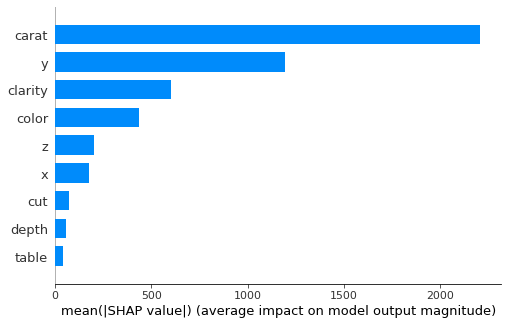

In [111]:
shap.summary_plot(
    shap_values_xgb, X_train, feature_names=X_train.columns, plot_type="bar"
)

The carat stands out as the driving factor for a diamond's price. Reading the axis title below, we see that the importances are just the average of absolute Shapley values for a feature. We can check that below:

In [94]:
pd.DataFrame(shap_values_xgb, columns=X_train.columns)["carat"].abs().mean()

2209.358

But that's no different than the feature importances plot you would get from XGBoost:

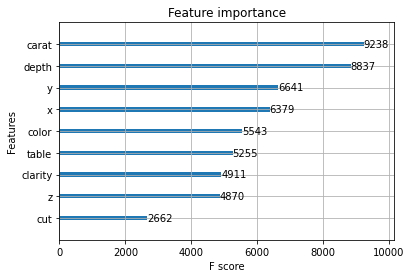

In [106]:
xgb.plot_importance(booster_xgb);

That's where we are wrong. You cannot trust feature importances from XGBoost because they are inconsistent across different calculations. Watch how feature importances change with the calculation type:

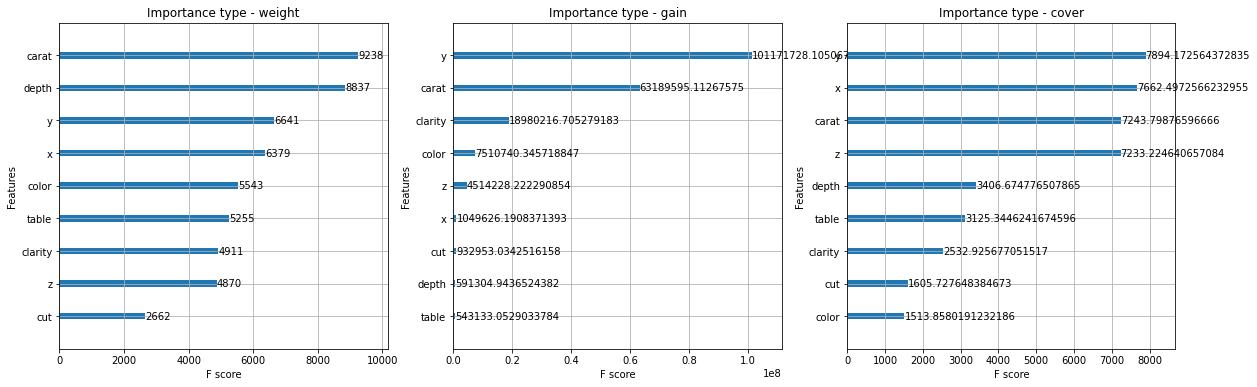

In [105]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for ax, imp_type in zip(axes.flatten(), ["weight", "gain", "cover"]):
    xgb.plot_importance(
        booster_xgb,
        ax=ax,
        importance_type=imp_type,
        title=f"Importance type - {imp_type}",
    )

plt.show();

Feature importances obtained from Shapley values are consistent and trustworthy. 

We won't also stop here. In the above plots, we only looked at absolute values of importance. We don't know which feature positively or negatively influences the model. Let's do that with SHAP `summary_plot`:

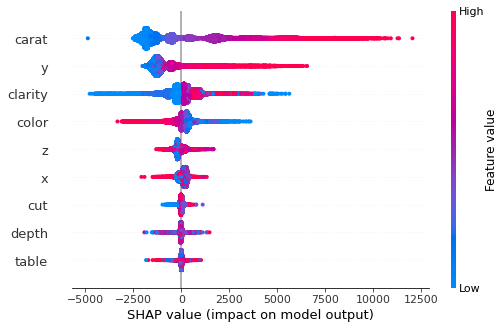

In [110]:
shap.summary_plot(shap_values_xgb, X_train, feature_names=X_train.columns);

Here is how to interpret the above plot:

1. The vertical left axis denotes feature names and they are ordered based on importance from top to bottom. 
2. The horizontal axis represents the magnitude of the SHAP values for predictions.
3. The vertical right axis represents the actual magnitude of a feature as it appears in the dataset and colors the points.

We see that as carat increases, its effect to model is more positive. The same is true for `y` feature. The `x` and `z` features are a bit tricky with a cluster of mixed points around the center. 

# Code

In [45]:
%%time

# SHAP interactions with XGB
interactions_xgb = booster_xgb.predict(
    xgb.DMatrix(X_train, y_train), pred_interactions=True
)

Wall time: 15.3 s


In [46]:
interactions_xgb.shape

(45849, 10, 10)